In [68]:
import pandas as pd;
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.17.0'

In [69]:
df = pd.read_excel("C:\\Users\\Ramte\\Documents\\4th year\\new\\Active Power Load - 33_11KV - Godishala Substation .xlsx")
data1=df['POWER (KW)']

Best Parameters: {'DC': 0, 'alpha': 500, 'init': 1, 'tau': 0.1, 'tol': 1e-06}
Best Score: 163141374.62334722


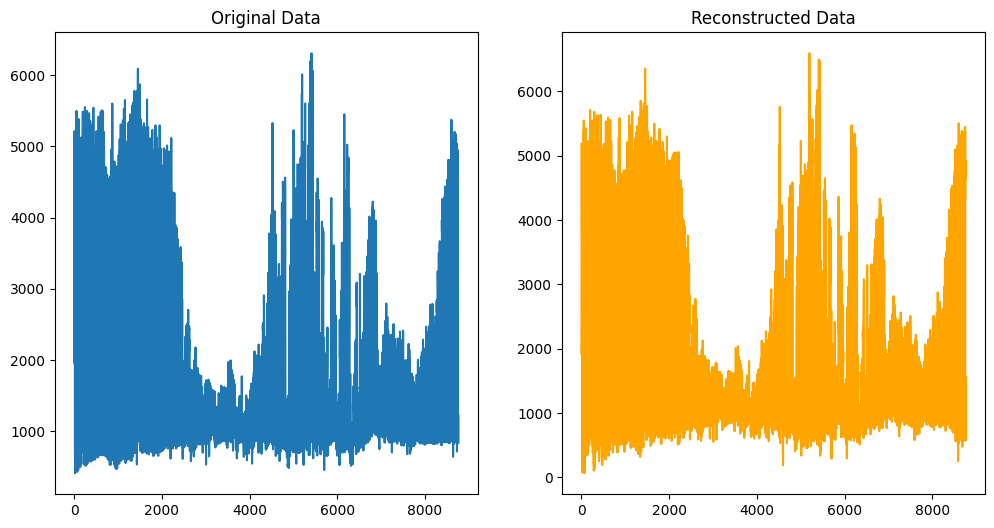

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from vmdpy import VMD
from sklearn.model_selection import ParameterGrid

# Evaluation function for VMD
def evaluate_vmd(alpha, tau, DC, init, tol, K, data):
    # Run VMD with the given parameters
    modes, u_hat, omega = VMD(data, alpha, tau, K, DC, init, tol)

    # Calculate residual energy score (lower is better)
    residual_energy_score = np.sum((data - np.sum(modes, axis=0))**2)

    # Calculate orthogonality score (lower is better)
    orthogonality_score = sum(np.abs(np.dot(modes[i], modes[j])) /
                               (np.linalg.norm(modes[i]) * np.linalg.norm(modes[j]))
                               for i in range(K) for j in range(i + 1, K))

    # Calculate spectral entropy for mode sparsity (lower is better)
    spectral_entropy_score = 0
    for mode in modes:
        psd = np.abs(np.fft.fft(mode))**2
        psd /= np.sum(psd)  # Normalize the power spectrum
        entropy = -np.sum(psd * np.log(psd + 1e-12))  # Avoid log(0)
        spectral_entropy_score += entropy

    # Combine scores into a final score (lower is better)
    total_score = residual_energy_score + orthogonality_score + spectral_entropy_score
    
    return total_score

# Define the parameter grid for automatic search
param_grid = {
    'alpha': [500, 1000, 2000],
    'tau': [0.0, 0.1],
    'DC': [0],
    'init': [1],
    'tol': [1e-6, 1e-7],
}


# Number of modes K
K = 4

# Grid search for best parameters
grid = ParameterGrid(param_grid)

best_score = float('inf')
best_params = None

# Loop through all combinations of parameters in the grid
for params in grid:
    score = evaluate_vmd(**params, K=K, data=data1)  # Run VMD with these params
    
    if score < best_score:
        best_score = score
        best_params = params

# Output the best parameters and score
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Run final VMD using the best parameters
alpha = best_params['alpha']
tau = best_params['tau']
DC = best_params['DC']
init = best_params['init']
tol = best_params['tol']

# Final VMD execution
modes, u_hat, omega = VMD(data1, alpha, tau, K, DC, init, tol)

# Reconstruct the original data from modes
reconstructed_data = np.sum(modes, axis=0)

# Plot original vs reconstructed data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(data1, label='Original Data')
plt.title('Original Data')
plt.subplot(1, 2, 2)
plt.plot(reconstructed_data, label='Reconstructed Data', color='orange')
plt.title('Reconstructed Data')
plt.show()

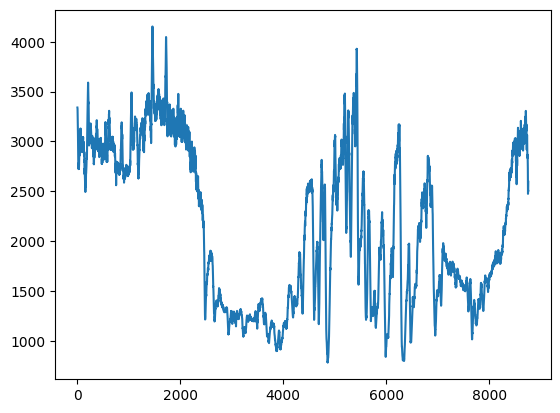

In [71]:
plt.plot(modes[0])

In [73]:
df=pd.DataFrame(modes[2])
df.to_csv('mode3_4hourly.csv',index=False)
df=pd.DataFrame(modes[0])
df.to_csv('mode1_4hourly.csv',index=False)
df=pd.DataFrame(modes[1])
df.to_csv('mode2_4hourly.csv',index=False)
df=pd.DataFrame(modes[3])
df.to_csv('mode4_4hourly.csv',index=False)

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
def create_input_output_pairs(data, window_length=30 * 24 , prediction_length=24, step_size=24 ):
    
    # Create input-output pairs
    num_samples = (len(data) - window_length - prediction_length) // step_size + 1
    X = np.array([data[i:i + window_length] for i in range(0, num_samples * step_size, step_size)])
    y = np.array([data[i + window_length:i + window_length + prediction_length] for i in range(0, num_samples * step_size, step_size)])
    # Diving the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    return X_train,X_test,y_train,y_test

In [57]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler5 = MinMaxScaler(feature_range=(0, 1))
# Reshape and fit-transform the modes
modes_scaled=[0,0,0,0]
modes_scaled[0] = scaler1.fit_transform(modes[0].reshape(-1, 1)).flatten()

modes_scaled[1] = scaler2.fit_transform(modes[1].reshape(-1, 1)).flatten()

modes_scaled[2] = scaler3.fit_transform(modes[2].reshape(-1, 1)).flatten()

modes_scaled[3] = scaler4.fit_transform(modes[3].reshape(-1, 1)).flatten()


In [58]:
data1_scaled = scaler5.fit_transform(data1.values.reshape(-1, 1)).flatten()

In [59]:
X_train_1,X_test_1,y_train_1,y_test_1 = create_input_output_pairs(modes_scaled[0])

In [60]:
X_train_2,X_test_2,y_train_2,y_test_2 = create_input_output_pairs(modes_scaled[1])

In [61]:
X_train_3,X_test_3,y_train_3,y_test_3 = create_input_output_pairs(modes_scaled[2])

In [62]:
X_train_4,X_test_4,y_train_4,y_test_4 = create_input_output_pairs(modes_scaled[3])

In [63]:
X_train_undeco,X_test_undeco,y_train_undeco,y_test_undeco = create_input_output_pairs(data1_scaled)

In [64]:
y_train_1=scaler1.inverse_transform(y_train_1)
y_train_2=scaler2.inverse_transform(y_train_2)
y_train_3=scaler3.inverse_transform(y_train_3)
y_train_4=scaler4.inverse_transform(y_train_4)
y_train_undeco=scaler5.inverse_transform(y_train_undeco)

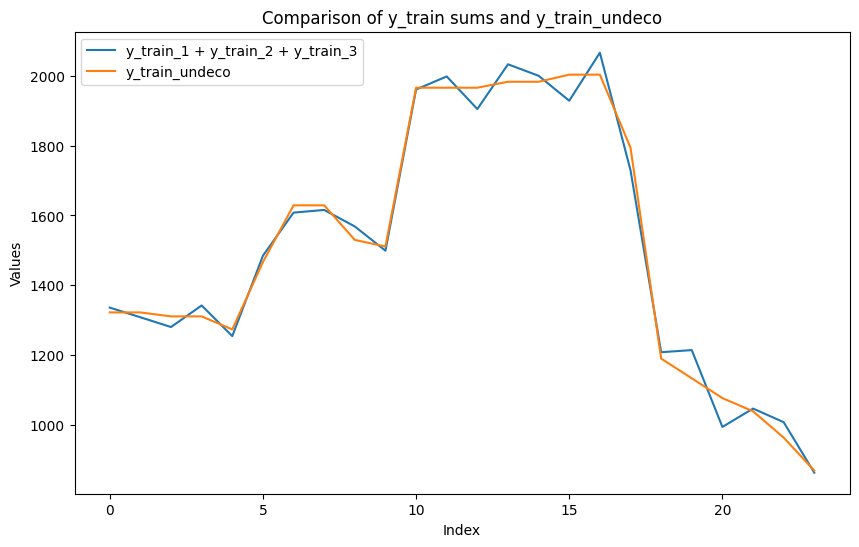

In [67]:
import matplotlib.pyplot as plt

# Assuming y_train_1, y_train_2, y_train_3, and y_train_undeco are defined
plt.figure(figsize=(10, 6))  # Set the figure size for better readability

# Plot the sum of y_train_1, y_train_2, and y_train_3
plt.plot((y_train_1[100] + y_train_2[100] + y_train_3[100]+y_train_4[100]), label='y_train_1 + y_train_2 + y_train_3')

# Plot y_train_undeco
plt.plot(y_train_undeco[100], label='y_train_undeco')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of y_train sums and y_train_undeco')
plt.legend()

# Show the plot
plt.show()